<a href="https://colab.research.google.com/github/ksnugroho/feel-in/blob/main/model-baseline-machine-learning/01_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Model**

**Thesis: Emotion Detection in Indonesian Text**

Kuncahyo Setyo Nugroho<br>
Supervisor:
1. Dr. Eng. Fitra A. Bachtiar, S.T., M.Eng.
2. Prof. Ir. Wayan Firdaus Mahmudy, S.Si., M.T., Ph.D.

Faculty of Computer Science, Brawijaya University, Indonesia &copy; 2021-2022

# 01 Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

In [15]:
import re
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import cycle
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
tqdm.pandas()

SEED = 50
FOLDER_PATH = 'model-baseline-machine-learning'

np.random.seed(SEED)

%matplotlib inline

# 02 Load Data

In [4]:
df = pd.read_csv('data/final-tweet-anotasi.csv', index_col=0)
# df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)   # For shuffle
print(df.head())

                                               tweet    label
0        wah belom liat muka gue lagi murka hahahaha      joy
1  Mungkin kurang piknik adrenalin. Mereka yg ske...    anger
2  maaf kalo tersinggung "orang kurus cepet mati"...    anger
3  berserah pada maha esa paling tabah dan sabar ...      joy
4                       Ehekk malu la hahahahahahaha  sadness


In [5]:
# df = df.dropna()

In [6]:
df.shape

(2243, 2)

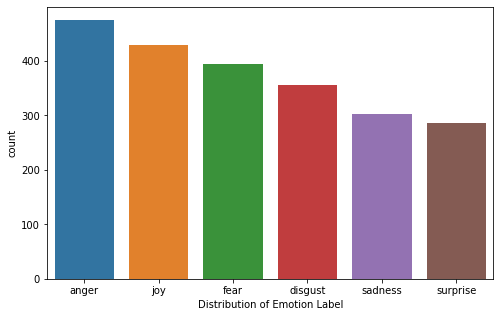

anger       475
disgust     355
fear        395
joy         429
sadness     303
surprise    286
Name: label, dtype: int64

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.xlabel('Distribution of Emotion Label')
plt.show()

df['label'].value_counts().sort_index()

# 03 Preprocessing

## Text Cleaning

In [8]:
def text_cleaning(text):
    text = text.lower()                               # Mengubah teks menjadi lower case
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
    text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
    text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
    text = text.strip()                               # Menghapus whitespaces

    return text

In [9]:
%%time
df['tweet'] = df['tweet'].progress_apply(text_cleaning)

100%|██████████| 2243/2243 [00:00<00:00, 67362.34it/s]

CPU times: user 40.6 ms, sys: 1.5 ms, total: 42.1 ms
Wall time: 40.8 ms


## Label Encoder

In [10]:
le = LabelEncoder()

df['label_encode'] = le.fit_transform(df['label'])
print(df.head())

                                               tweet    label  label_encode
0        wah belom liat muka gue lagi murka hahahaha      joy             3
1  mungkin kurang piknik adrenalin mereka yg skep...    anger             0
2  maaf kalo tersinggung orang kurus cepet mati w...    anger             0
3  berserah pada maha esa paling tabah dan sabar ...      joy             3
4                       ehekk malu la hahahahahahaha  sadness             4


In [11]:
le_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_mapping)

{'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}


In [12]:
LABEL_NAME = le.classes_
print(LABEL_NAME)

['anger' 'disgust' 'fear' 'joy' 'sadness' 'surprise']


# 04 Feature Extraction

In [13]:
X = df['tweet']
y = df['label_encode']

In [16]:
tf_idf = TfidfVectorizer(ngram_range=(1,2))
tf_idf.fit(X)

print(len(tf_idf.get_feature_names_out()))

39389


In [41]:
vocab = tf_idf.vocabulary_

In [17]:
X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
X_tf_idf.shape

(2243, 39389)

# 05 Train & Test Data Splitting

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y, test_size=0.20, random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1794, 39389), (449, 39389), (1794,), (449,))

# 06 Modeling

In [21]:
# Define machine learning models
models = [
          ('KNN', KNeighborsClassifier()),
          ('NAIVE BAYES', MultinomialNB()),
          ('SVM', SVC()),
          ('DECISION TREE', DecisionTreeClassifier()),
          ('RANDOM FOREST', RandomForestClassifier())
        ]

In [22]:
def truncate(n, decimals=0):
  multiplier = 10 ** decimals
  return int(n * multiplier) / multiplier

In [23]:
%%time

for name, model in models:
  print(f'[INFO] Loading using {name} ...')
  clf = model.fit(X_train, y_train)
  model_predict = clf.predict(X_test)                               # model prediction
  train_accuracy = accuracy_score(y_train, clf.predict(X_train))    # get training accuracy
  
  print('[INFO] Cross validation:')
  cross_validation = ShuffleSplit(n_splits=10, test_size=0.2, random_state=SEED)
  for i, score in enumerate(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cross_validation)):
    cv_accuracy_mean = truncate(score.mean(), 3)
    print(f'\tAccuracy for the fold no. {i} on the test set: {truncate(score, 3)}')

  test_accuracy = accuracy_score(y_test, model_predict)

  print(f'\n[INFO] Training accuracy: {truncate(train_accuracy, 3)}')
  print(f'[INFO] Cross validation accuracy: {cv_accuracy_mean}')
  print(f'[INFO] Testing accuracy: {truncate(test_accuracy, 3)}\n')

print('[INFO] Done ..,')

[INFO] Loading using KNN ...
[INFO] Cross validation:
	Accuracy for the fold no. 0 on the test set: 0.551
	Accuracy for the fold no. 1 on the test set: 0.579
	Accuracy for the fold no. 2 on the test set: 0.559
	Accuracy for the fold no. 3 on the test set: 0.534
	Accuracy for the fold no. 4 on the test set: 0.557
	Accuracy for the fold no. 5 on the test set: 0.565
	Accuracy for the fold no. 6 on the test set: 0.529
	Accuracy for the fold no. 7 on the test set: 0.593
	Accuracy for the fold no. 8 on the test set: 0.554
	Accuracy for the fold no. 9 on the test set: 0.551

[INFO] Training accuracy: 0.711
[INFO] Cross validation accuracy: 0.551
[INFO] Testing accuracy: 0.527

[INFO] Loading using NAIVE BAYES ...
[INFO] Cross validation:
	Accuracy for the fold no. 0 on the test set: 0.523
	Accuracy for the fold no. 1 on the test set: 0.52
	Accuracy for the fold no. 2 on the test set: 0.445
	Accuracy for the fold no. 3 on the test set: 0.512
	Accuracy for the fold no. 4 on the test set: 0.518


# 07 Hyperparameter Tuning

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
%%time

rf = RandomForestClassifier() # Based model

rf_parameters = {
    'bootstrap': [True],
    'max_depth': [10, 30, None], 
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
    }

grid = GridSearchCV(estimator=rf, param_grid=rf_parameters, refit=True, cv=cross_validation, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
CPU times: user 45.4 s, sys: 3.03 s, total: 48.4 s
Wall time: 36min 52s


In [28]:
# print best parameter after tuning 
print(grid.best_params_) 

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 300}


In [ ]:
grid.get_params

# 08 Evaluation

In [66]:
y_pred = grid.predict(X_test)
y_true = y_test

print(f'Accuracy: {truncate(accuracy_score(y_true, y_pred), 3)}')

Accuracy: 0.792


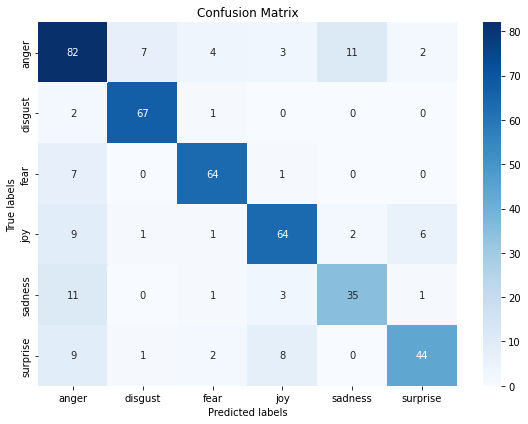

In [31]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')  # annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(LABEL_NAME)
ax.yaxis.set_ticklabels(LABEL_NAME)
plt.tight_layout()

In [32]:
print(classification_report(y_pred, y_true, target_names=LABEL_NAME))

              precision    recall  f1-score   support

       anger       0.75      0.68      0.72       120
     disgust       0.96      0.88      0.92        76
        fear       0.89      0.88      0.88        73
         joy       0.77      0.81      0.79        79
     sadness       0.69      0.73      0.71        48
    surprise       0.69      0.83      0.75        53

    accuracy                           0.79       449
   macro avg       0.79      0.80      0.79       449
weighted avg       0.80      0.79      0.79       449



In [33]:
def plot_roc_curve(y_test, y_pred):
  
  n_classes = len(np.unique(y_test))
  y_test = label_binarize(y_test, classes=np.arange(len(LABEL_NAME)))
  y_pred = label_binarize(y_pred, classes=np.arange(len(LABEL_NAME)))

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  
  # Compute micro-average ROC curve and ROC area
  fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

  # Plot all ROC curves
  plt.figure(figsize=(10, 7))
  lw = 2
  plt.plot(fpr['micro'], tpr['micro'],
    label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
    color='deeppink', linestyle=':', linewidth=4,)

  plt.plot(fpr['macro'], tpr['macro'],
    label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
    color='navy', linestyle=':', linewidth=4,)

  colors = cycle(['aqua', 'darkorange', 'darkgreen', 'yellow', 'blue', 'red'])
  for i, color, label in zip(range(n_classes), colors, LABEL_NAME):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(label, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) curve')
  plt.legend()
  plt.show()

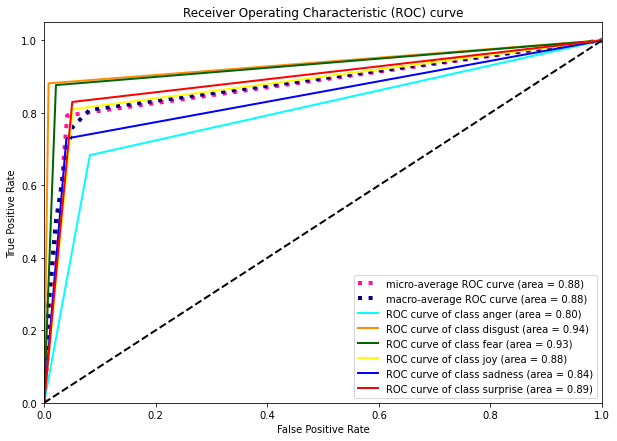

In [38]:
plot_roc_curve(y_pred, y_true)

# 09 Predict on New Data

In [64]:
new_text = 'Hargai kebahagiaan jika kamu pernah sedih'

pre_input_text = text_cleaning(new_text)                            # Lakukan text pre processing pada text input
tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))                 # Definisikan TF_IDF dan load voba dari feature extraction
predict = grid.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi

print(predict, LABEL_NAME[(predict)])

[4] ['sadness']
